In [1]:
import torch
import torch.nn as nn
import numpy as np
from collections import OrderedDict

In [2]:
def get_mgrid(sidelen, dim=2):
    '''
    -1에서 1까지 균등하게 나눈 정규화된 좌표 그리드(flattened)를 생성하는 함수.
    Implicit Neural Representation에서 위치 정보를 입력으로 줄 때 자주 사용됨.

    Args:
        sidelen (int): 한 축 방향의 해상도. 예: 32 -> 각 축에 대해 32개의 점 생성
        dim (int): 좌표 차원. 2이면 (x, y), 3이면 (x, y, z) 형태의 격자 생성

    Returns:
        torch.Tensor: (sidelen**dim, dim) 형태의 tensor. 예: dim=2, sidelen=32 → (1024, 2)
                      각 행은 [-1, 1] 범위에서 균등하게 분포된 좌표 하나를 의미함
    '''
    
    # 각 차원에 대해 [-1, 1] 범위로 균등 분포된 1D tensor를 생성 (linespace는 linspace 오타로 추정됨)
    tensor = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])

    # meshgrid를 생성하여 모든 차원의 좌표 조합을 만듦
    mgrid = torch.stack(torch.meshgrid(*tensor, indexing='ij'), dim=-1)

    # 그리드를 (전체 좌표 수, 차원 수) 형태로 평탄화
    mgrid = mgrid.reshape(-1, dim)
    
    return mgrid


In [3]:
# Sine 함수를 비선형 활성화 함수로 사용하는 커스텀 레이어
class SineLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True, is_first=False, omega_0=0):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        self.in_features = in_features
        self.out_features = out_features
        
        # 선형 변환 정의
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        self.init_weights()
        
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                # 첫 번째 layer는 기본적인 Xavier 초기화
                self.linear.weight.uniform_(-1 / self.in_features, 1 / self.in_features)
            else:
                # 이후 layer는 omega_0를 고려한 작은 초기값으로 weight 초기화
                limit = np.sqrt(6 / self.in_features) / self.omega_0
                self.linear.weight.uniform_(-limit, limit)
    
    def forward(self, x):
        # SIREN의 핵심: ω₀ * (Linear(x)) → sin
        return torch.sin(self.omega_0 * self.linear(x))
    
    def forward_with_intermediate(self, x):
        # 중간 결과(선형 변환 이후 값)도 함께 반환
        intermediate = self.omega_0 * self.linear(x)
        return torch.sin(intermediate), intermediate

# SIREN 모델: 여러 SineLayer를 쌓아 구성
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features,
                 outermost_linear=False, first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        net = []
        
        # 첫 번째 SineLayer (높은 주파수 특징 학습)
        net += [SineLayer(in_features, hidden_features, is_first=True, omega_0=first_omega_0)]
        
        # 중간 hidden SineLayer 반복
        for _ in range(hidden_layers):
            net += [SineLayer(hidden_features, hidden_features, omega_0=hidden_omega_0)]
        
        # 마지막 layer: 선형 또는 sine 중 선택
        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            with torch.no_grad():
                limit = np.sqrt(6 / hidden_features) / hidden_omega_0
                final_linear.weight.uniform_(-limit, limit)
            net += [final_linear]
        else:
            net += [SineLayer(hidden_features, out_features, omega_0=hidden_omega_0)]
        
        self.net = nn.Sequential(*net)
    
    def forward(self, coords):
        # 입력 좌표에 대해 requires_grad를 켜서 이후 미분 가능하게 함
        coords = coords.clone().detach().requires_grad_(True)
        output = self.net(coords)
        return output, coords 
    
    def forward_with_activations(self, coords, retain_grad=False):
        # 중간 활성값을 추적하는 함수 (시각화 용도)
        activations = OrderedDict()
        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x

        for layer in self.net:
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                activations[f'{layer.__class__.__name__}_{activation_count}'] = intermed
            else:
                x = layer(x)
                if retain_grad:
                    x.retain_grad()
                activations[f'{layer.__class__.__name__}_{activation_count}'] = x
            activation_count += 1
        
        return activations

# 모델 인스턴스 생성
model = Siren(
    in_features=2,         # 입력 좌표 (예: (lon, lat))
    hidden_features=256,   # hidden layer의 차원 수
    hidden_layers=3,       # 중간 hidden layer 개수
    out_features=1,        # 출력 (예: u-wind 하나만 예측)
    outermost_linear=True  # 마지막은 sine이 아닌 선형층
)

# CUDA로 올리기
model.cuda()

Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [7]:
# 필요한 모듈 import
from PIL import Image
import skimage.data
import torch
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.utils.data import Dataset, DataLoader

# 카메라맨 흑백 이미지를 텐서로 변환하는 함수
def get_cameraman_tensor(sidelength):
    # Scikit-image 내장 예제 이미지 로드 (512x512 grayscale)
    img = Image.fromarray(skimage.data.camera())  # numpy 배열을 Pillow 이미지 객체로 변경경

    # torchvision transform을 이용한 전처리 정의
    transform = Compose([
        Resize(sidelength),                             # 지정한 크기로 resize
        ToTensor(),                                     # [H, W] → [1, H, W] 형태의 이미지(3d) 텐서로 변환
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))  # [-1, 1] 범위로 정규화
    ])

    # 이미지에 transform 적용
    img = transform(img)  # shape: [1, sidelength, sidelength]
    return img

# INR 모델이 사용할 custom dataset 정의
class ImageFitting(Dataset):
    def __init__(self, sidelength):
        super().__init__()
        
        # 카메라맨 이미지 불러오기 및 전처리
        img = get_cameraman_tensor(sidelength)

        # 이미지 텐서 → (H, W, C) → (H*W, C) 로 flatten (여기선 C=1)
        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        print(f"ImageFitting 함수 : {self.pixels} {self.pixels.shape}")

        # 좌표값 생성: [-1, 1] 범위의 (x, y) 그리드
        self.coords = get_mgrid(sidelength, dim=2)

    def __len__(self):
        # 데이터셋은 하나의 이미지이므로 길이는 1
        return 1

    def __getitem__(self, idx):
        if idx > 0:
            raise IndexError  # 인덱스는 0 하나만 허용

        # 좌표와 해당 위치의 픽셀값 (grayscale intensity)을 반환
        return self.coords, self.pixels

# 해상도 설정 (예: 256x256)
sidelength = 256

# 데이터셋 및 데이터로더 생성
cameramen_dataset = ImageFitting(sidelength)
dataloader = DataLoader(cameramen_dataset,
                        batch_size=1,
                        pin_memory=True,
                        num_workers=0)

for coords, values in dataloader:
    print('좌표 (lat, lon, time): ', coords.shape)
    print("출력 (u_wimd, humidity):", values.shape)
    break

ImageFitting 함수 : tensor([[0.5608],
        [0.5686],
        [0.5686],
        ...,
        [0.1529],
        [0.1529],
        [0.1765]]) torch.Size([65536, 1])
좌표 (lat, lon, time):  torch.Size([1, 65536, 2])
출력 (u_wimd, humidity): torch.Size([1, 65536, 1])


torch.Size([1, 65536, 2])
Step [  0/500], Loss 0.3241


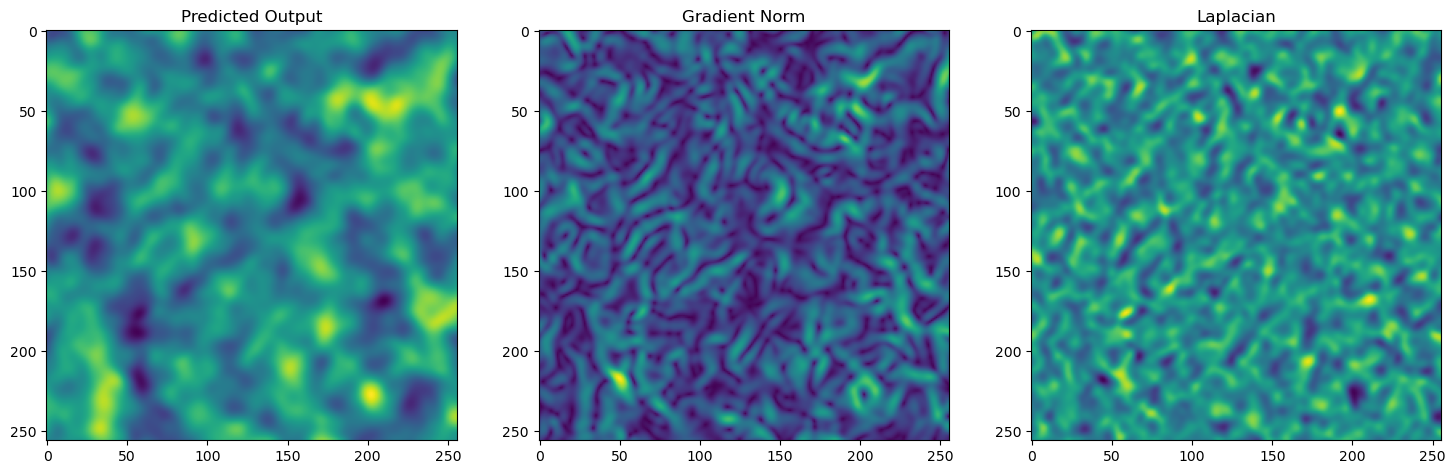

Step [100/500], Loss 0.0086


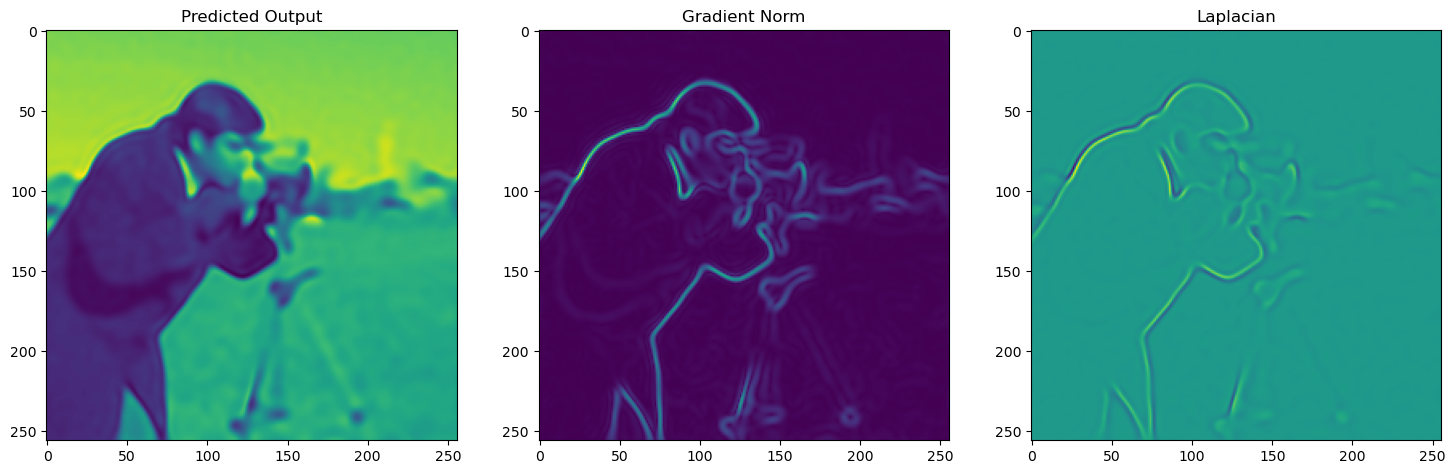

Step [200/500], Loss 0.0043


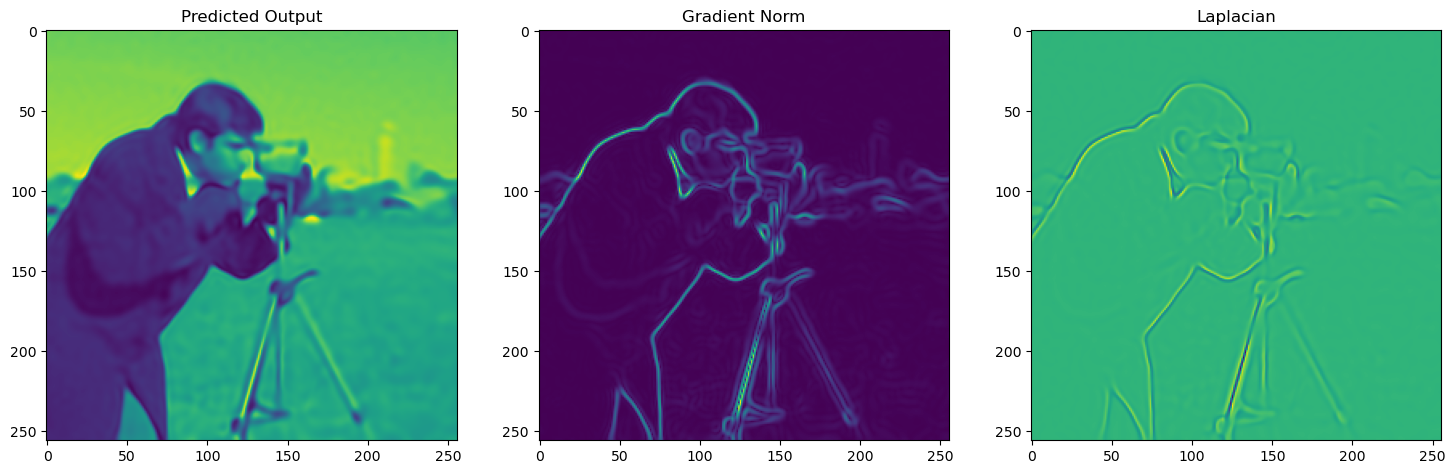

Step [300/500], Loss 0.0021


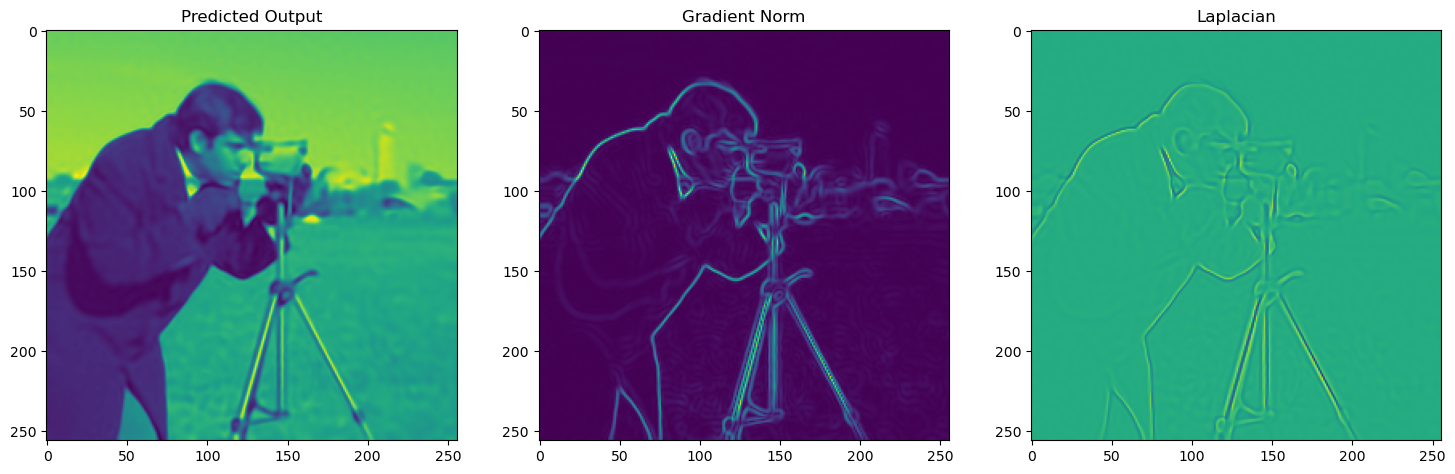

Step [400/500], Loss 0.0013


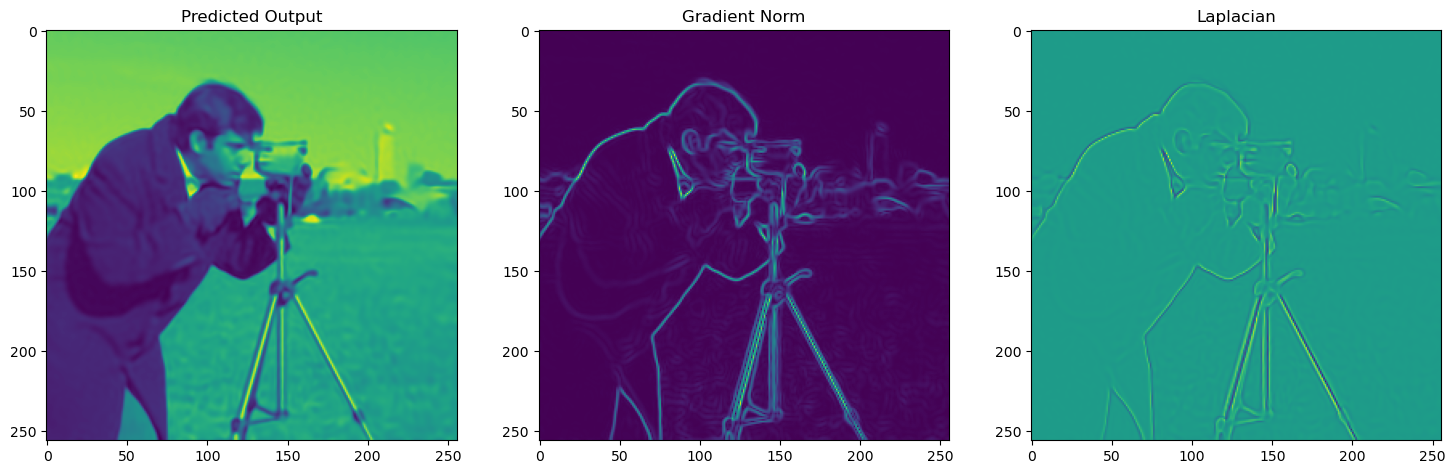

In [5]:
import matplotlib.pyplot as plt
# from utils import gradient, laplace 


def gradient(y, x):
    grad = torch.autograd.grad(
        outputs=y,
        inputs=x,
        grad_outputs=torch.ones_like(y),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    return grad

def laplace(y, x):
    grad = gradient(y, x)
    lap = 0.0
    for i in range(grad.shape[-1]):
        lap += torch.autograd.grad(
            grad[..., i],
            x,
            grad_outputs=torch.ones_like(grad[..., i]),
            create_graph=True,
            retain_graph=True,
            only_inputs=True
        )[0][..., i]
    return lap

#전체 학습 반복 횟수 및 시각화 주기 설정
total_steps = 500                 # 총 학습 반복 횟수
steps_til_summary = 100           # 일정 스텝마다 중간 결과를 출력 및 시각화

# 최적화 알고리즘 설정 (Adam 옵티마이저 사용)
optim = torch.optim.Adam(model.parameters(), lr=1e-4)

# 데이터 로딩 (DataLoader에서 첫 번째 배치만 꺼냄)
model_input, ground_truth = next(iter(dataloader))
# print(f"{model_input.shape} !!!!!!!!!!!!!")
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()
print(model_input.shape)
# 학습 루프 시작
for step in range(total_steps):
    # 모델에 입력을 주고 예측값과 해당 좌표를 얻음
    model_output, coords = model(model_input)

    # 손실 계산 (Mean Squared Error)
    loss = ((model_output - ground_truth) ** 2).mean()

    # 일정 step마다 중간 결과 출력 및 시각화
    if not step % steps_til_summary:
        print(f'Step [{step:3d}/{total_steps:3d}], Loss {loss.item():.4f}')
        
        # 그래디언트(gradient)와 라플라시안(laplacian) 계산
        img_grad = gradient(model_output, coords)
        img_laplacian = laplace(model_output, coords)

        # 결과 시각화 (원본 예측값, gradient norm, laplacian 값)
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        # 1. 모델 출력값 시각화
        axes[0].imshow(model_output.cpu().view(sidelength, sidelength).detach().numpy())
        axes[0].set_title("Predicted Output")

        # 2. gradient norm 시각화
        axes[1].imshow(img_grad.norm(dim=-1).cpu().view(sidelength, sidelength).detach().numpy())
        axes[1].set_title("Gradient Norm")

        # 3. laplacian 시각화
        axes[2].imshow(img_laplacian.cpu().view(sidelength, sidelength).detach().numpy())
        axes[2].set_title("Laplacian")

        plt.show()

    # 역전파 및 파라미터 업데이트
    optim.zero_grad()
    loss.backward()
    optim.step()


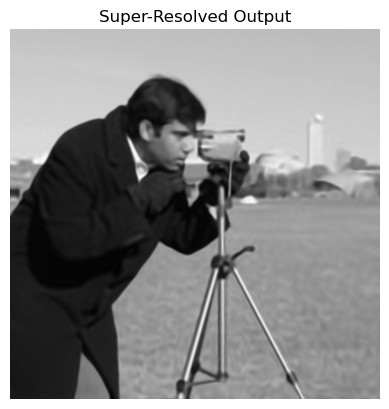

In [6]:
# 고해상도(super-resolution) 출력을 위한 해상도 설정
SR_sidelength = 1024  # 1024 x 1024 해상도로 출력하고자 할 때

# 해당 해상도에 맞는 좌표 grid 생성 (정규화된 [-1, 1] 범위)
SR_coords = get_mgrid(SR_sidelength)  # shape: (1024*1024, 2)

# 모델을 평가 모드로 전환 (dropout 등 비활성화)
model.eval()

# 모델에 고해상도 좌표 입력하여 출력 생성
SR_model_output, _ = model(SR_coords.cuda())  # shape: (1024*1024, 1)

# 고해상도 출력 이미지를 2D로 변환하여 시각화
plt.imshow(SR_model_output.cpu().view(SR_sidelength, SR_sidelength).detach().numpy(), cmap='gray')
plt.title("Super-Resolved Output")
plt.axis('off')
plt.show()